## Imports

In [1]:
!nvidia-smi

Sun Apr 18 09:55:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
from PIL import Image

In [3]:
device = torch.device("cuda")

In [307]:
# !wget -O content.jpg https://cdn.sozvezdie-tour.ru/images/uploadedfiles/fed20ae1-f278-4db2-b414-63b6dd6142de.jpg
!wget -O  content.jpg --no-check-certificate https://img.geliophoto.com/arkh/07_arkh.jpg

# van gogh
!wget -O style1.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

# edward munch
!wget -O style2.jpg https://lh3.googleusercontent.com/proxy/oYnxRLDcWZKhpZ6uEgD-xYf9OUSJ5hjHZNjZnPPLS2lyBpFm_hDNYzG8ceckbiSQZ-Bg3AgHZGVrODEHmjI

--2021-04-18 12:03:54--  https://img.geliophoto.com/arkh/07_arkh.jpg
Resolving img.geliophoto.com (img.geliophoto.com)... 92.38.145.145, 2a03:90c0:9996::9996
Connecting to img.geliophoto.com (img.geliophoto.com)|92.38.145.145|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1194662 (1.1M) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>]   1.14M  --.-KB/s    in 0.008s  

2021-04-18 12:03:54 (145 MB/s) - ‘content.jpg’ saved [1194662/1194662]

--2021-04-18 12:03:54--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540189 (528K)

In [308]:
size = 384

transform = transforms.Compose([transforms.Resize(size),
                             transforms.CenterCrop((size, size)),
                             transforms.ToTensor()])

def load(img_name):
    img = Image.open(img_name)
    img = transform(img)
    img = img.unsqueeze(0)
    return img.to(device, torch.float)

def show(img):
  img = img.squeeze()
  img = img.cpu().numpy().transpose(1, 2, 0)
  img = (img * 255).astype('uint8')
  plt.imshow(img)
  plt.axis('off')
  

In [309]:
style_img_1 = load("style1.jpg")
style_img_2 = load('style2.jpg')
content_img = load("content.jpg")

In [310]:
print(style_img_1.size())
print(style_img_2.size())
print(content_img.size())

torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])


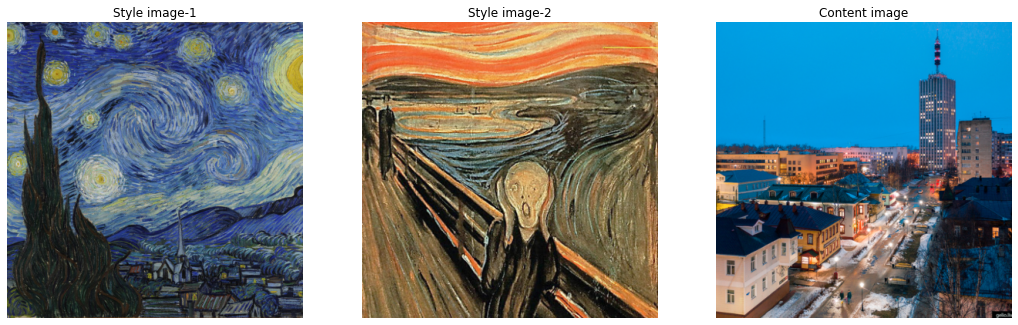

In [312]:
plt.figure(figsize=(18,7))
plt.subplot(1,3,1)
plt.title('Style image-1')
show(style_img_1)

plt.subplot(1,3,2)
plt.title('Style image-2')
show(style_img_2)

plt.subplot(1,3,3)
plt.title('Content image')
show(content_img)


In [313]:
# load pretrained vgg feature extractor

vgg_model = models.vgg19(pretrained=True).features.to(device).eval()

## Loss

In [314]:
# Content loss

class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target.detach())
        return input

In [359]:
# Style loss

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self._gram_matrix(target_feature)

    def _gram_matrix(self, input):
        _, c, h, w = input.size()  
        features = input.view(c, h * w)
        gram = torch.mm(features, features.t())
        return gram

    def forward(self, input):
        _, c, h, w = input.size()
        gram = self._gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target.detach()) / (h * w * c)
        return input

## Create model

In [360]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

In [361]:
def get_model(cnn_model, 
             style_img, 
             content_img):
    
    content_layers = ['conv_10']
    style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
    
    content_idx = ['10']
    style_idx = ['1', '3', '5', '9', '13']
    final_layer = 14

    cnn = copy.deepcopy(cnn_model)

    content_losses = []
    style_losses = []

    normalization = Normalization().to(device)
    model = nn.Sequential(normalization)

    i = 0  

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        if i == final_layer:
            break

        model.add_module(name, layer)
        
        if name in content_layers:       
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    return model, style_losses, content_losses

## Style transfer

In [363]:
def style_transfer(cnn, 
                   content_img, 
                   style_img, 
                   input_img, 
                   iters=100, 
                   alpha=1, 
                   betta=1e5):

    model, style_losses, content_losses = get_model(cnn, style_img, content_img)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    iteration = 0
    while iteration < iters:

        def closure():
            nonlocal iteration
            
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss

            for cl in content_losses:
                content_score += cl.loss

            content_score *= alpha
            style_score *= betta

            loss = style_score + content_score
            loss.backward()

            iteration += 1
            if iteration % 20 == 0:
                print(f"iter: {iteration}")
                print('Style Loss : {:4f}'.format(style_score.item()))
                print('Content Loss: {:4f}'.format(content_score.item()))
                show(input_img.data.clamp_(0, 1))
                plt.show()
                print()
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

iter: 20
Style Loss : 3474491904.000000
Content Loss: 84.076881


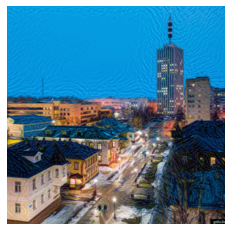


iter: 40
Style Loss : 1543272576.000000
Content Loss: 105.337418


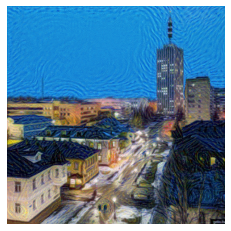


iter: 60
Style Loss : 569998848.000000
Content Loss: 115.264664


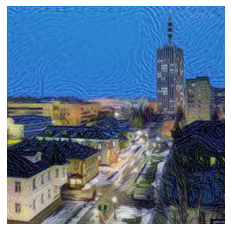


iter: 80
Style Loss : 255026064.000000
Content Loss: 121.656616


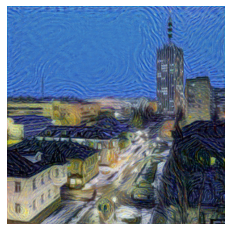


iter: 100
Style Loss : 138453520.000000
Content Loss: 124.640030


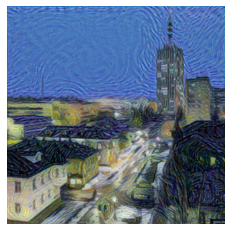


iter: 120
Style Loss : 76171896.000000
Content Loss: 127.884415


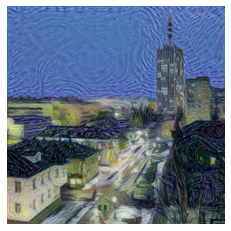


iter: 140
Style Loss : 50912404.000000
Content Loss: 130.138153


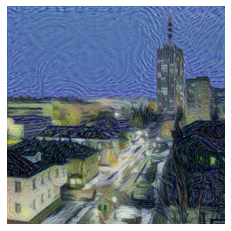


iter: 160
Style Loss : 38023688.000000
Content Loss: 132.282135


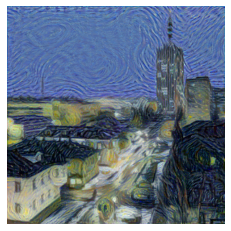


iter: 180
Style Loss : 30983280.000000
Content Loss: 133.930801


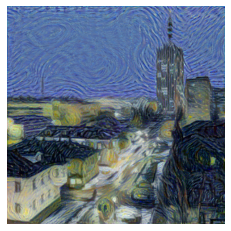


iter: 200
Style Loss : 26147620.000000
Content Loss: 134.875168


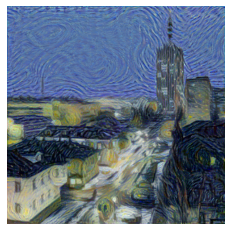


iter: 220
Style Loss : 22248166.000000
Content Loss: 135.842590


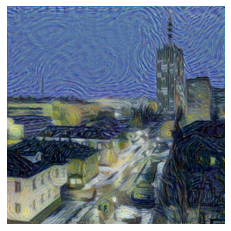


iter: 240
Style Loss : 18991542.000000
Content Loss: 136.897568


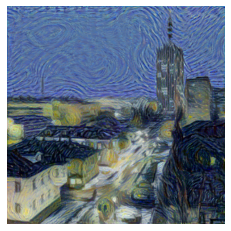


iter: 260
Style Loss : 16195518.000000
Content Loss: 137.515457


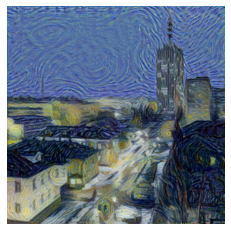


iter: 280
Style Loss : 14027586.000000
Content Loss: 137.908356


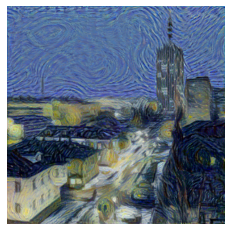


iter: 300
Style Loss : 12087966.000000
Content Loss: 138.379913


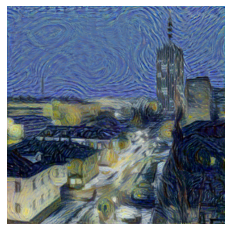

In [375]:
output = style_transfer(vgg_model, content_img, style_img_1, content_img.clone(), iters=300, betta=1e6)

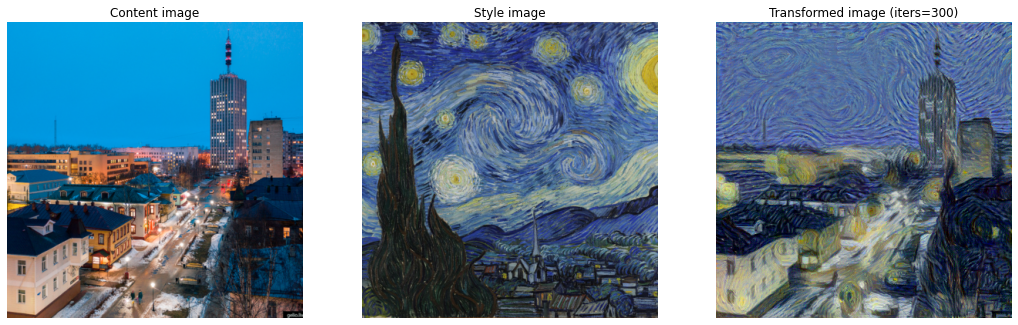

In [377]:
plt.figure(figsize=(18, 7))
plt.subplot(1,3,1)
plt.title('Content image')
show(content_img)

plt.subplot(1,3,2)
plt.title('Style image')
show(style_img_1)

plt.subplot(1,3,3)
plt.title('Transformed image (iters=300)')
show(output.detach())

iter: 20
Style Loss : 557821460480.000000
Content Loss: 98.193375


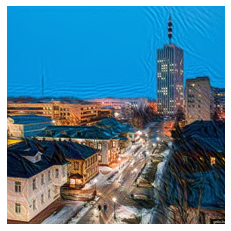


iter: 40
Style Loss : 245163163648.000000
Content Loss: 115.638702


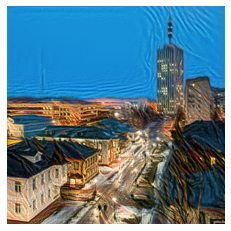


iter: 60
Style Loss : 110338768896.000000
Content Loss: 125.298004


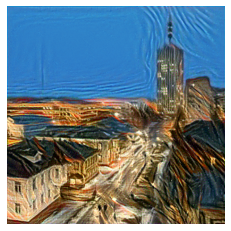


iter: 80
Style Loss : 58525896704.000000
Content Loss: 131.529861


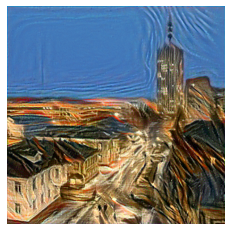


iter: 100
Style Loss : 38140452864.000000
Content Loss: 135.262802


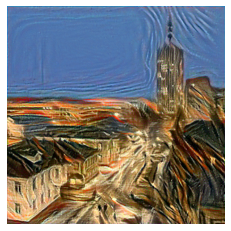


iter: 120
Style Loss : 24514316288.000000
Content Loss: 138.174301


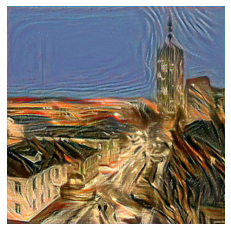


iter: 140
Style Loss : 16906341376.000000
Content Loss: 141.371490


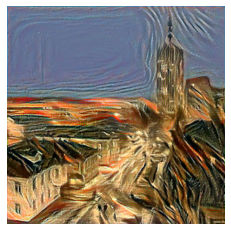


iter: 160
Style Loss : 11702937600.000000
Content Loss: 144.099609


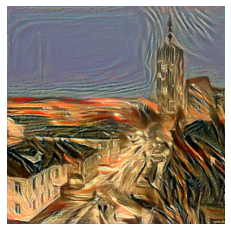


iter: 180
Style Loss : 8069258752.000000
Content Loss: 146.626709


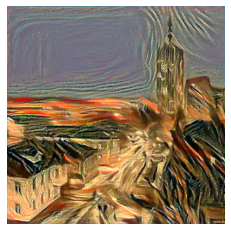


iter: 200
Style Loss : 5707741696.000000
Content Loss: 148.107254


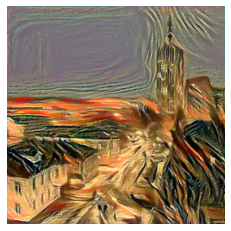


iter: 220
Style Loss : 4203957248.000000
Content Loss: 149.378586


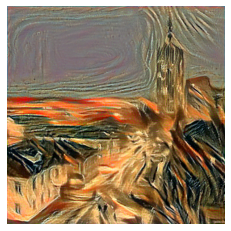


iter: 240
Style Loss : 3260260096.000000
Content Loss: 150.695007


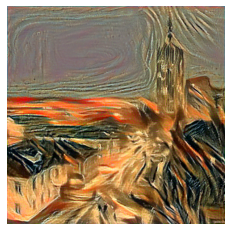


iter: 260
Style Loss : 2640589824.000000
Content Loss: 151.657959


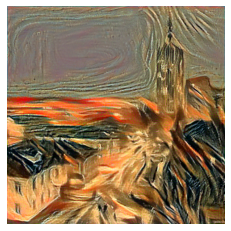


iter: 280
Style Loss : 2198844160.000000
Content Loss: 152.568802


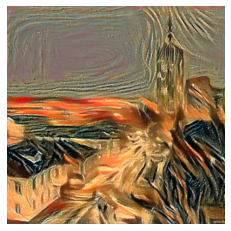


iter: 300
Style Loss : 1911837056.000000
Content Loss: 153.326736


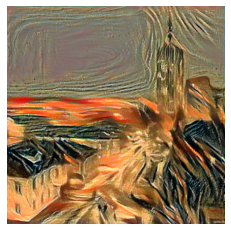

In [367]:
output = style_transfer(vgg_model, content_img, style_img_2, content_img.clone(), iters=300, betta=1e8)

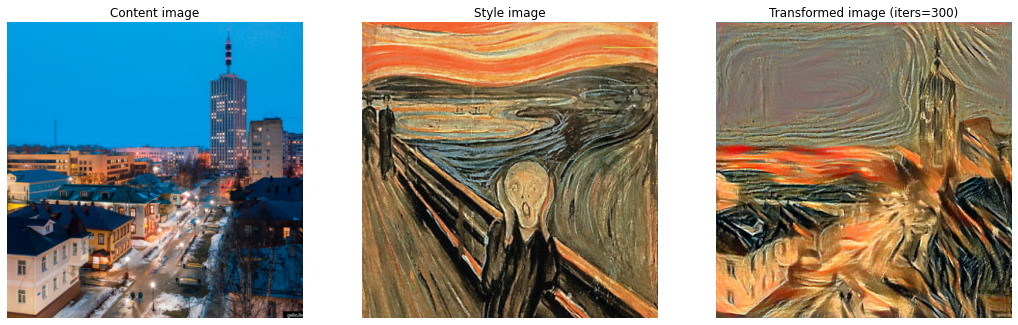

In [368]:
plt.figure(figsize=(18, 7))
plt.subplot(1,3,1)
plt.title('Content image')
show(content_img)

plt.subplot(1,3,2)
plt.title('Style image')
show(style_img_2)

plt.subplot(1,3,3)
plt.title('Transformed image (iters=300)')
show(output.detach())

iter: 20
Style Loss : 549883805696.000000
Content Loss: 100.939781


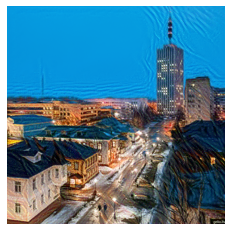


iter: 40
Style Loss : 228637589504.000000
Content Loss: 117.168091


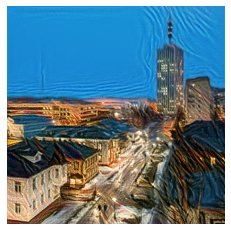


iter: 60
Style Loss : 106923302912.000000
Content Loss: 125.291122


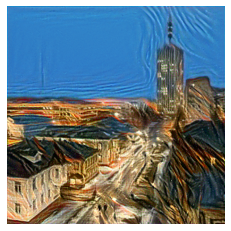


iter: 80
Style Loss : 57730011136.000000
Content Loss: 131.736160


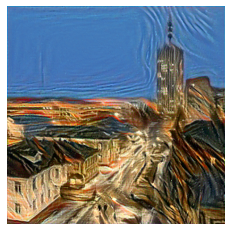


iter: 100
Style Loss : 34769633280.000000
Content Loss: 135.681793


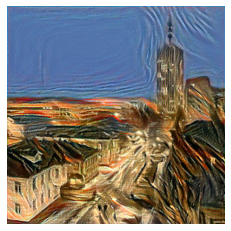

In [373]:
output = style_transfer(vgg_model, content_img, style_img_2, content_img.clone(), iters=100, betta=1e8)

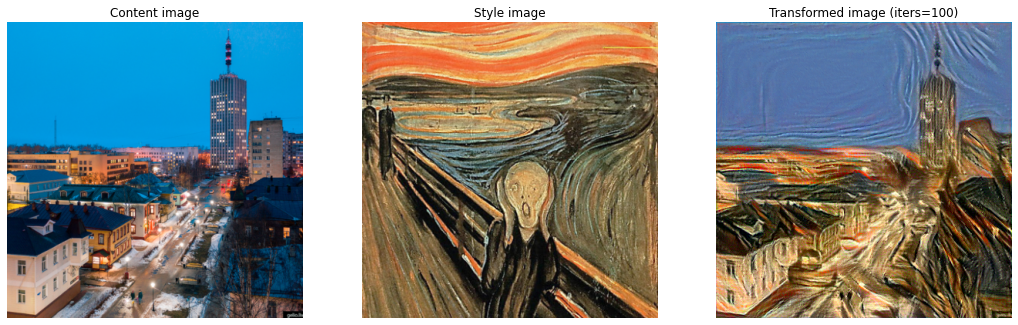

In [374]:
plt.figure(figsize=(18, 7))
plt.subplot(1,3,1)
plt.title('Content image')
show(content_img)

plt.subplot(1,3,2)
plt.title('Style image')
show(style_img_2)

plt.subplot(1,3,3)
plt.title('Transformed image (iters=100)')
show(output.detach())